## Goal: define project paths and choose a default weekend.

In [1]:
from pathlib import Path
import fastf1

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
RAW = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

YEAR = 2023   # change if you prefer
ROUND = 1     # we'll confirm after listing the schedule

print("Project root:", ROOT)
print("Raw data dir:", RAW)
print("Default weekend:", YEAR, "round", ROUND)


Project root: C:\Users\maxnd\Documents\Machine Learning\f1-race-predictor
Raw data dir: C:\Users\maxnd\Documents\Machine Learning\f1-race-predictor\data\raw
Default weekend: 2023 round 1


- We set consistent paths and a default weekend (2023, Round 1 – Bahrain).
- I can change the YEAR and ROUND after I view the season schedule next.
- We define project paths and ensure the raw data folder exists.
- FastF1 cache is enabled so future loads are fast and reproducible.

## Picking a season and viewing the schedule

- This lists all events for the chosen year so you can pick a round.
- We’ll use your chosen round in the next cell to pull FP1 data.

In [2]:
# Goal: choose a weekend confidently by listing the season schedule.
YEAR = 2023  # change this later if you want
schedule = fastf1.get_event_schedule(YEAR, include_testing=False)
schedule.loc[:, ["RoundNumber", "EventName", "EventDate", "EventFormat"]]


req         WARNING 	DEFAULT CACHE ENABLED! (3.0 GB) C:\Users\maxnd\AppData\Local\Temp\fastf1


,RoundNumber,EventName,EventDate,EventFormat
1,1,Bahrain Grand Prix,2023-03-05,conventional
2,2,Saudi Arabian Grand Prix,2023-03-19,conventional
3,3,Australian Grand Prix,2023-04-02,conventional
4,4,Azerbaijan Grand Prix,2023-04-30,sprint_shootout
5,5,Miami Grand Prix,2023-05-07,conventional
6,6,Monaco Grand Prix,2023-05-28,conventional
7,7,Spanish Grand Prix,2023-06-04,conventional
8,8,Canadian Grand Prix,2023-06-18,conventional
9,9,Austrian Grand Prix,2023-07-02,sprint_shootout
10,10,British Grand Prix,2023-07-09,conventional


## Loading the FP1 for the chosen round and saving the raw laps

In [3]:
# Goal: load FP1 for a selected round and persist laps/weather to /data/raw.
ROUND = 1  # change after you inspect the schedule above

event = fastf1.get_event(YEAR, ROUND)
print(f"Selected: {event['EventName']} ({YEAR}) | Format: {event['EventFormat']}")

session = fastf1.get_session(YEAR, ROUND, 'FP1')
session.load()  # loads timing, laps, weather, messages (telemetry later if needed)

laps_path = RAW / f"laps_{YEAR}_R{ROUND}_FP1.csv"
session.laps.to_csv(laps_path, index=False)

# Weather is optional but usually present
if getattr(session, "weather_data", None) is not None:
    w_path = RAW / f"weather_{YEAR}_R{ROUND}_FP1.csv"
    session.weather_data.to_csv(w_path, index=False)
    print("Saved:", laps_path.name, "and", w_path.name, "| laps:", len(session.laps))
else:
    print("Saved:", laps_path.name, "| laps:", len(session.laps), "| weather: not available")


core           INFO 	Loading data for Bahrain Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Selected: Bahrain Grand Prix (2023) | Format: conventional


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '21', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


Saved: laps_2023_R1_FP1.csv and weather_2023_R1_FP1.csv | laps: 403


## Small helper to load & save any session
- Goal: one tiny function to load a session and persist laps/weather to /data/raw.
- This wraps FastF1 loading and writes CSVs with a consistent naming pattern.
- It returns the lap count so we can quickly sanity-check what we saved.

In [4]:
from pathlib import Path
import fastf1

def save_session_raw(year: int, round_no: int, code: str, raw_dir: Path) -> int:
    """code ∈ {'FP1','FP2','FP3','Q','R','S','SS'} depending on format."""
    sess = fastf1.get_session(year, round_no, code)
    sess.load()  # pulls timing, laps, weather, etc.
    base = f"{year}_R{round_no}_{code}"
    (raw_dir / f"laps_{base}.csv").write_text(sess.laps.to_csv(index=False))
    if getattr(sess, "weather_data", None) is not None:
        (raw_dir / f"weather_{base}.csv").write_text(sess.weather_data.to_csv(index=False))
    print(f"Saved {code}: laps={len(sess.laps)}")
    return len(sess.laps)


## Saving FP2 and FP3 (works for ‘conventional’; will skip if missing)
- Goal: run the helper for FP2 and FP3 for YEAR/ROUND already set above.
- We fetch FP2/FP3; sprint weekends may not have both, so we fail gracefully.
- Seeing lap counts confirms the sessions were downloaded and cached.

In [5]:
from pathlib import Path

for code in ["FP2", "FP3"]:
    try:
        save_session_raw(YEAR, ROUND, code, RAW)
    except Exception as e:
        print(f"{code} not available or failed: {e.__class__.__name__}: {e}")


core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '21', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 3 [v3.6.1]
req            INFO 	Using ca

Saved FP2: laps=522


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '4', '10', '11', '14', '16', '18', '20', '21', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


Saved FP3: laps=321


## Save Qualifying and Race
- Goal: persist Qualifying (Q) and Race (R) raw laps (always present).
- Qualifying and Race exist for all formats, so we always save them.
- These files are the backbone for later features (grid, results, penalties, etc.)

In [6]:
for code in ["Q", "R"]:
    save_session_raw(YEAR, ROUND, code, RAW)

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached d

Saved Q: laps=254


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


Saved R: laps=1056


## (Optional) SavING a single-row “weekend metadata” file

- Goal: capture the chosen event’s metadata for reproducibility.
- We store the event’s basic metadata beside the raw laps for traceability.
- It helps downstream code know what format (conventional vs sprint) we’re dealing with.

In [7]:
event = fastf1.get_event(YEAR, ROUND)
meta = (
    fastf1.get_event_schedule(YEAR, include_testing=False)
    .loc[lambda df: df["RoundNumber"] == ROUND]
)
meta_path = RAW / f"eventmeta_{YEAR}_R{ROUND}.csv"
meta.to_csv(meta_path, index=False)
meta[["RoundNumber","EventName","EventDate","EventFormat"]]


,RoundNumber,EventName,EventDate,EventFormat
1,1,Bahrain Grand Prix,2023-03-05,conventional


## /data/processed folder + tiny CSV loader
- This parses LapTime correctly.
- Reading from CSV keeps my steps reproducible and fast (which uses my cached data).

In [8]:
# Goal: ensure a processed folder exists and add a tiny helper to read raw laps CSVs.
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
RAW = ROOT / "data" / "raw"
PROCESSED = ROOT / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

def read_laps_csv(year:int, round_no:int, code:str) -> pd.DataFrame:
    """Load laps_{year}_R{round}_{code}.csv from /data/raw and parse times."""
    path = RAW / f"laps_{year}_R{round_no}_{code}.csv"
    df = pd.read_csv(path)
    # Parse LapTime if present; FastF1 exports timedeltas as strings
    if "LapTime" in df.columns:
        df["LapTime"] = pd.to_timedelta(df["LapTime"], errors="coerce")
    return df
print("Processed dir:", PROCESSED)


Processed dir: C:\Users\maxnd\Documents\Machine Learning\f1-race-predictor\data\processed


## Building practice pace aggregates (FP1–FP3)

- Goal: extract per-driver practice pace: median long-run lap, mean lap, total laps.
- We compute a defensible FP pace: average lap pace and a long-run median (stints ≥5 laps).
- Outputs are saved to /data/processed for reuse and inspection.

In [9]:
import numpy as np

def practice_features(year:int, round_no:int) -> pd.DataFrame:
    frames = []
    for code in ["FP1","FP2","FP3"]:
        try:
            laps = read_laps_csv(year, round_no, code)
        except FileNotFoundError:
            continue
        if laps.empty or "Driver" not in laps.columns:
            continue

        # Valid laps: not in/out laps, with a laptime, and accurate if the flag exists
        valid = laps.copy()
        for col in ["PitInLap","PitOutLap","IsAccurate"]:
            if col in valid.columns:
                if col in ["PitInLap","PitOutLap"]:
                    valid = valid[~valid[col].fillna(False)]
                else:
                    valid = valid[valid[col].fillna(True)]
        valid = valid[valid["LapTime"].notna()]

        # Long-run proxy = laps from stints with >=5 green laps
        if {"Driver","Stint"}.issubset(valid.columns):
            stint_sizes = (valid.groupby(["Driver","Stint"])["LapTime"]
                                .transform("size"))
            longrun = valid[stint_sizes >= 5]
        else:
            longrun = pd.DataFrame(columns=valid.columns)

        grp_all = valid.groupby("Driver")["LapTime"]
        grp_lr  = longrun.groupby("Driver")["LapTime"] if not longrun.empty else None

        df = pd.DataFrame({
            "Driver": grp_all.count().index,
            f"{code}_mean_all_s": grp_all.mean().dt.total_seconds().values,
            f"{code}_laps": grp_all.count().values,
        })
        # median long-run (fallback to overall median if no long-run for that driver)
        med_all = grp_all.median().dt.total_seconds()
        med_lr = (grp_lr.median().dt.total_seconds()
                  if grp_lr is not None else pd.Series(dtype=float))
        df[f"{code}_median_longrun_s"] = df["Driver"].map(med_lr).fillna(
            df["Driver"].map(med_all)
        )
        frames.append(df)

    if not frames:
        return pd.DataFrame()

    out = frames[0]
    for f in frames[1:]:
        out = out.merge(f, on="Driver", how="outer")

    # Simple combined aggregates across FP1–FP3
    mean_cols = [c for c in out.columns if c.endswith("_mean_all_s")]
    medlr_cols = [c for c in out.columns if c.endswith("_median_longrun_s")]
    lap_cols = [c for c in out.columns if c.endswith("_laps")]

    out["fp_mean_all_s"] = out[mean_cols].mean(axis=1, skipna=True)
    out["fp_median_longrun_s"] = out[medlr_cols].mean(axis=1, skipna=True)
    out["fp_total_laps"] = out[lap_cols].sum(axis=1, skipna=True).astype(int)

    return out.sort_values("Driver").reset_index(drop=True)

YEAR, ROUND = 2023, 1  # stick with Bahrain 2023 for now
fp_feats = practice_features(YEAR, ROUND)
fp_path = PROCESSED / f"practice_features_{YEAR}_R{ROUND}.csv"
fp_feats.to_csv(fp_path, index=False)
fp_feats.head()


,Driver,FP1_mean_all_s,FP1_laps,FP1_median_longrun_s,FP2_mean_all_s,FP2_laps,FP2_median_longrun_s,FP3_mean_all_s,FP3_laps,FP3_median_longrun_s,fp_mean_all_s,fp_median_longrun_s,fp_total_laps
0,ALB,108.091714,7,97.0240,101.704100,20,98.0580,111.536000,7,94.4850,107.110605,96.522333,34
1,ALO,112.108071,14,95.8790,103.729278,18,97.3835,112.239000,6,102.6665,109.358783,98.643000,38
2,BOT,103.471444,9,98.3250,102.306588,17,98.7330,105.995600,5,94.3560,103.924544,97.138000,31
3,DEV,112.668312,16,101.3695,106.006947,19,98.7985,112.380909,11,123.2250,110.352056,107.797667,46
4,GAS,113.915533,15,96.4210,106.414611,18,98.1260,116.431000,8,120.2675,112.253715,104.938167,41


## Qualifying: best laps (Q1/Q2/Q3), position, and delta to pole

- Goal: pull qualifying results from cache, compute best qual time and delta to pole.
- We take the minimum of Q1/Q2/Q3 per driver and compute Δ to pole in seconds.
- These are the core qual features we’ll use with practice pace and grid.

In [10]:
# Goal: pull qualifying results from cache, compute best qual time and delta to pole.
import fastf1
import pandas as pd

q = fastf1.get_session(YEAR, ROUND, "Q")
q.load()

res = q.results[["Abbreviation","Position","Q1","Q2","Q3"]].copy()
for col in ["Q1","Q2","Q3"]:
    res[col] = pd.to_timedelta(res[col], errors="coerce")

res["best_qual_t"] = res[["Q1","Q2","Q3"]].min(axis=1, skipna=True)
pole = res["best_qual_t"].min()
res["delta_to_pole_s"] = (res["best_qual_t"] - pole).dt.total_seconds()
res = res.rename(columns={"Abbreviation":"Driver","Position":"qual_pos"})

q_path = PROCESSED / f"qualifying_features_{YEAR}_R{ROUND}.csv"
res.to_csv(q_path, index=False)
res.head()


core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']


,Driver,qual_pos,Q1,Q2,Q3,best_qual_t,delta_to_pole_s
1,VER,1.0,0 days 00:01:31.295000,0 days 00:01:30.503000,0 days 00:01:29.708000,0 days 00:01:29.708000,0.000
11,PER,2.0,0 days 00:01:31.479000,0 days 00:01:30.746000,0 days 00:01:29.846000,0 days 00:01:29.846000,0.138
16,LEC,3.0,0 days 00:01:31.094000,0 days 00:01:30.282000,0 days 00:01:30,0 days 00:01:30,0.292
55,SAI,4.0,0 days 00:01:30.993000,0 days 00:01:30.515000,0 days 00:01:30.154000,0 days 00:01:30.154000,0.446
14,ALO,5.0,0 days 00:01:31.158000,0 days 00:01:30.645000,0 days 00:01:30.336000,0 days 00:01:30.336000,0.628


## Starting grid from Race results (captures penalties)

- The Race session stores the final grid used on Sunday, capturing any penalties.
- We’ll later compare grid_pos to qual_pos to quantify grid drops.

In [11]:
# Goal: get actual grid positions (after penalties) from the Race classification.
r = fastf1.get_session(YEAR, ROUND, "R")
r.load()

grid = r.results[["Abbreviation","GridPosition"]].rename(
    columns={"Abbreviation":"Driver","GridPosition":"grid_pos"}
)
grid_path = PROCESSED / f"grid_{YEAR}_R{ROUND}.csv"
grid.to_csv(grid_path, index=False)
grid.head()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


,Driver,grid_pos
1,VER,1.0
11,PER,2.0
14,ALO,5.0
55,SAI,4.0
44,HAM,7.0


## Merge into a single driver-race table for the weekend

- Goal: produce one row per driver with FP + Quali + Grid features for this GP.
- We build a clean driver-race row with practice pace, qual position/time, Δ to pole, and grid (incl. penalties).
- This is our base for Phase 2 feature engineering (we’ll add rolling form, reliability, tyres, weather, etc.).

In [12]:
df = (fp_feats.merge(res[["Driver","qual_pos","best_qual_t","delta_to_pole_s"]], on="Driver", how="outer")
              .merge(grid, on="Driver", how="outer"))

# Helpful numeric cleanup
df["qual_pos"] = pd.to_numeric(df["qual_pos"], errors="coerce")
df["grid_pos"]  = pd.to_numeric(df["grid_pos"], errors="coerce")
df["grid_drop"] = df["grid_pos"] - df["qual_pos"]  # +ve means penalty/drop

final_path = PROCESSED / f"features_weekend_{YEAR}_R{ROUND}.csv"
df.to_csv(final_path, index=False)
df.sort_values(["grid_pos","qual_pos"]).head(12)


,Driver,FP1_mean_all_s,FP1_laps,FP1_median_longrun_s,FP2_mean_all_s,FP2_laps,FP2_median_longrun_s,FP3_mean_all_s,FP3_laps,FP3_median_longrun_s,fp_mean_all_s,fp_median_longrun_s,fp_total_laps,qual_pos,best_qual_t,delta_to_pole_s,grid_pos,grid_drop
18,VER,97.793083,12,98.5175,99.753812,16,97.2295,119.725167,6,125.3715,105.757354,107.039500,34,1.0,0 days 00:01:29.708000,0.000,1.0,0.0
11,PER,97.844583,12,98.6470,97.000412,17,97.7850,102.165500,4,94.5725,99.003498,97.001500,33,2.0,0 days 00:01:29.846000,0.138,2.0,0.0
7,LEC,99.683833,6,97.0145,96.771800,15,97.8610,99.882300,10,99.2730,98.779311,98.049500,31,3.0,0 days 00:01:30,0.292,3.0,0.0
14,SAI,104.727500,12,100.3260,99.022389,18,98.3400,108.389727,11,99.1780,104.046539,99.281333,41,4.0,0 days 00:01:30.154000,0.446,4.0,0.0
1,ALO,112.108071,14,95.8790,103.729278,18,97.3835,112.239000,6,102.6665,109.358783,98.643000,38,5.0,0 days 00:01:30.336000,0.628,5.0,0.0
13,RUS,105.735214,14,97.7240,105.070706,17,98.3060,95.965714,7,96.3730,102.257211,97.467667,38,6.0,0 days 00:01:30.340000,0.632,6.0,0.0
5,HAM,99.092000,5,95.1640,100.736000,17,98.4000,94.593143,7,93.5080,98.140381,95.690667,29,7.0,0 days 00:01:30.384000,0.676,7.0,0.0
16,STR,111.775667,9,103.4800,105.031474,19,98.5750,115.331111,9,118.2650,110.712750,106.773333,37,8.0,0 days 00:01:30.836000,1.128,8.0,0.0
10,OCO,114.197714,14,101.9830,106.813158,19,98.4780,113.032818,11,96.5850,111.347897,99.015333,44,9.0,0 days 00:01:30.914000,1.206,9.0,0.0
6,HUL,99.492706,17,98.5790,101.417588,17,98.9320,104.003500,14,100.4945,101.637931,99.335167,48,10.0,0 days 00:01:30.809000,1.101,10.0,0.0


## Race stints & tyres summary (per driver)
- Goal: summarize race stints/tyres into compact driver features.
- We condense race laps into per-driver stint length, pace, pitstops, and tyre mix.
- This becomes part of our driver-race features for modeling and simulation.

In [13]:
import pandas as pd
import numpy as np

def race_stints_features(year:int, round_no:int) -> pd.DataFrame:
    laps = read_laps_csv(year, round_no, "R")
    if laps.empty or not {"Driver","LapTime"}.issubset(laps.columns):
        return pd.DataFrame()

    valid = laps.copy()
    for col in ["PitInLap","PitOutLap","IsAccurate"]:
        if col in valid.columns:
            if col in ["PitInLap","PitOutLap"]:
                valid = valid[~valid[col].fillna(False)]
            else:
                valid = valid[valid[col].fillna(True)]
    valid = valid[valid["LapTime"].notna()]

    if "Stint" not in valid.columns:
        return pd.DataFrame()  # older seasons may miss this; we’ll handle later via OpenF1

    grp = valid.groupby(["Driver","Stint"])
    stint = pd.DataFrame({
        "stint_len": grp["LapTime"].size(),
        "stint_mean_s": grp["LapTime"].mean().dt.total_seconds(),
        "stint_median_s": grp["LapTime"].median().dt.total_seconds(),
    }).reset_index()

    if "Compound" in valid.columns:
        comp_mode = grp["Compound"].agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
        stint = stint.merge(comp_mode.rename("compound_mode").reset_index(), on=["Driver","Stint"], how="left")

    per_driver = stint.groupby("Driver").agg(
        pitstops=("Stint", lambda s: int(s.nunique() - 1)),
        avg_stint_len=("stint_len","mean"),
        median_stint_len=("stint_len","median"),
        stint_count=("Stint","nunique"),
        mean_race_pace_s=("stint_median_s","mean")
    ).reset_index()

    if "compound_mode" in stint.columns:
        comp_counts = stint.pivot_table(index="Driver", columns="compound_mode",
                                        values="Stint", aggfunc="count", fill_value=0)
        comp_counts.columns = [f"stints_{c.lower()}" for c in comp_counts.columns]
        per_driver = per_driver.merge(comp_counts.reset_index(), on="Driver", how="left")

    out_path = PROCESSED / f"race_stints_{year}_R{round_no}.csv"
    per_driver.to_csv(out_path, index=False)
    return per_driver.sort_values("Driver")

stints_feats = race_stints_features(YEAR, ROUND)
stints_feats.head()

,Driver,pitstops,avg_stint_len,median_stint_len,stint_count,mean_race_pace_s,stints_hard,stints_medium,stints_soft
0,ALB,3,12.500000,12.5,4,98.919625,1,0,3
1,ALO,2,17.000000,18.0,3,98.345500,2,0,1
2,BOT,2,16.666667,16.0,3,99.145833,2,0,1
3,DEV,2,16.333333,14.0,3,99.735833,2,0,1
4,GAS,3,12.500000,13.5,4,98.633000,2,0,2


## Weather summary (race)
-  Goal: store a tiny weather summary for the race (means of key fields).
-  We keep a compact race-weather summary (means only) to explain pace differences.
- If weather is absent for a session, we just skip gracefully.

In [14]:
import pandas as pd

def weather_summary(year:int, round_no:int, code:str="R") -> pd.DataFrame:
    path = RAW / f"weather_{year}_R{round_no}_{code}.csv"
    if not path.exists():
        return pd.DataFrame()
    w = pd.read_csv(path)
    cols = [c for c in ["AirTemp","TrackTemp","Humidity","Pressure","WindSpeed","Rainfall"] if c in w.columns]
    if not cols:
        return pd.DataFrame()
    summ = w[cols].mean(numeric_only=True).to_frame(name="mean").T
    summ["session"] = code
    out = PROCESSED / f"weather_summary_{year}_R{round_no}_{code}.csv"
    summ.to_csv(out, index=False)
    return summ

weather_r = weather_summary(YEAR, ROUND, "R")
weather_r

,AirTemp,TrackTemp,Humidity,Pressure,WindSpeed,Rainfall,session
mean,27.431677,31.011801,21.496894,1016.863975,0.68323,0.0,R


## Merge extended features for the weekend
- Goal: join practice + quali + grid + stints (and keep it as our weekend feature set).
- This creates a single, tidy driver-race table for this GP with FP, Q, grid, and stints.
- We’ll add rolling form, reliability, track history, etc., in Phase 2.

In [15]:
extended = (df.merge(stints_feats, on="Driver", how="left")  # df came from earlier Cell 5
              .sort_values(["grid_pos","qual_pos","Driver"]))
ext_path = PROCESSED / f"features_weekend_ext_{YEAR}_R{ROUND}.csv"
extended.to_csv(ext_path, index=False)
extended.head(12)

,Driver,FP1_mean_all_s,FP1_laps,FP1_median_longrun_s,FP2_mean_all_s,FP2_laps,FP2_median_longrun_s,FP3_mean_all_s,FP3_laps,FP3_median_longrun_s,...,grid_pos,grid_drop,pitstops,avg_stint_len,median_stint_len,stint_count,mean_race_pace_s,stints_hard,stints_medium,stints_soft
18,VER,97.793083,12,98.5175,99.753812,16,97.2295,119.725167,6,125.3715,...,1.0,0.0,2,16.666667,18.0,3,97.549333,1,0,2
11,PER,97.844583,12,98.6470,97.000412,17,97.7850,102.165500,4,94.5725,...,2.0,0.0,2,16.666667,15.0,3,97.743667,1,0,2
7,LEC,99.683833,6,97.0145,96.771800,15,97.8610,99.882300,10,99.2730,...,3.0,0.0,2,11.333333,11.0,3,98.104333,2,0,1
14,SAI,104.727500,12,100.3260,99.022389,18,98.3400,108.389727,11,99.1780,...,4.0,0.0,2,17.000000,16.0,3,98.503667,2,0,1
1,ALO,112.108071,14,95.8790,103.729278,18,97.3835,112.239000,6,102.6665,...,5.0,0.0,2,17.000000,18.0,3,98.345500,2,0,1
13,RUS,105.735214,14,97.7240,105.070706,17,98.3060,95.965714,7,96.3730,...,6.0,0.0,2,16.666667,16.0,3,98.724833,2,0,1
5,HAM,99.092000,5,95.1640,100.736000,17,98.4000,94.593143,7,93.5080,...,7.0,0.0,2,17.000000,16.0,3,98.652500,2,0,1
16,STR,111.775667,9,103.4800,105.031474,19,98.5750,115.331111,9,118.2650,...,8.0,0.0,2,16.666667,13.0,3,98.637167,2,0,1
10,OCO,114.197714,14,101.9830,106.813158,19,98.4780,113.032818,11,96.5850,...,9.0,0.0,3,8.000000,8.0,4,98.952250,3,0,1
6,HUL,99.492706,17,98.5790,101.417588,17,98.9320,104.003500,14,100.4945,...,10.0,0.0,3,12.250000,12.5,4,98.959000,2,0,2


## Quick sanity plot: FP long-run pace
-  Goal: eyeball practice long-run pace by driver.
-  A small bar chart helps confirm our practice metric behaves sensibly.
- Lower is faster; we’ll use these values in model features.

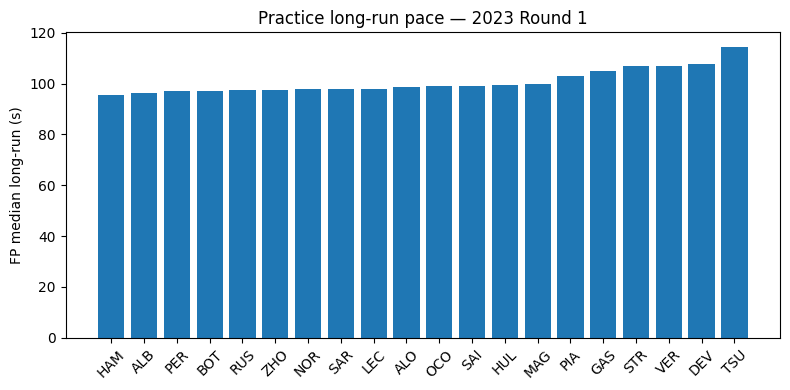

In [16]:
import matplotlib.pyplot as plt

plot_df = extended.dropna(subset=["fp_median_longrun_s"]).sort_values("fp_median_longrun_s")
plt.figure(figsize=(8,4))
plt.bar(plot_df["Driver"], plot_df["fp_median_longrun_s"])
plt.ylabel("FP median long-run (s)")
plt.title(f"Practice long-run pace — {YEAR} Round {ROUND}")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

## What I learned so far in phase 1

- Pulled FP1–FP3, Q, R and saved raw laps + weather (where available).
- Built tidy practice, qualifying, grid, and stints/tyres features.